In [14]:
%matplotlib inline
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

from datetime import datetime
import matplotlib.dates as mdates
import pylab
plt.style.use('seaborn-whitegrid')

mpl.rcParams['figure.figsize'] = (30, 15)
mpl.rcParams['axes.grid'] = True 

In [15]:
data1 = pd.read_csv('avg_block_size.csv')
data2 = pd.read_csv('transaction_fees.csv')
df = pd.merge(data1, data2, on='Timestamp', how='inner')
# 0
condition0_1 = 1.2
condition0_2 = 175
# 1
condition1_1 = 1
condition1_2 = 50
df['condition0_1'] = df['avg-block-size'].apply(lambda x: 1 if x>=condition0_1 else 0)
df['condition0_2'] = df['transaction-fees'].apply(lambda x: 1 if x>=condition0_2 else 0)
df["condition0"] = df['condition0_1'] * df['condition0_2']
df['condition1_1'] = df['avg-block-size'].apply(lambda x: 0 if x<=condition1_1 else 1)
df['condition1_2'] = df['transaction-fees'].apply(lambda x: 0 if x<=condition1_2 else 1)
df["condition1"] = df['condition1_1'] * df['condition1_2']
df['fragility'] = df['condition1']
df = df[['Timestamp', 'avg-block-size', 'transaction-fees', 'fragility']]
df.head()

,Timestamp,avg-block-size,transaction-fees,fragility
0,02/02/2016 00:00,0.695702,45.725885,0
1,05/02/2016 00:00,0.670505,45.430167,0
2,08/02/2016 00:00,0.690654,45.667819,0
3,11/02/2016 00:00,0.694514,41.329722,0
4,14/02/2016 00:00,0.691252,40.876409,0


In [16]:
df['fragility'].value_counts()

0    525
1    206
Name: fragility, dtype: int64

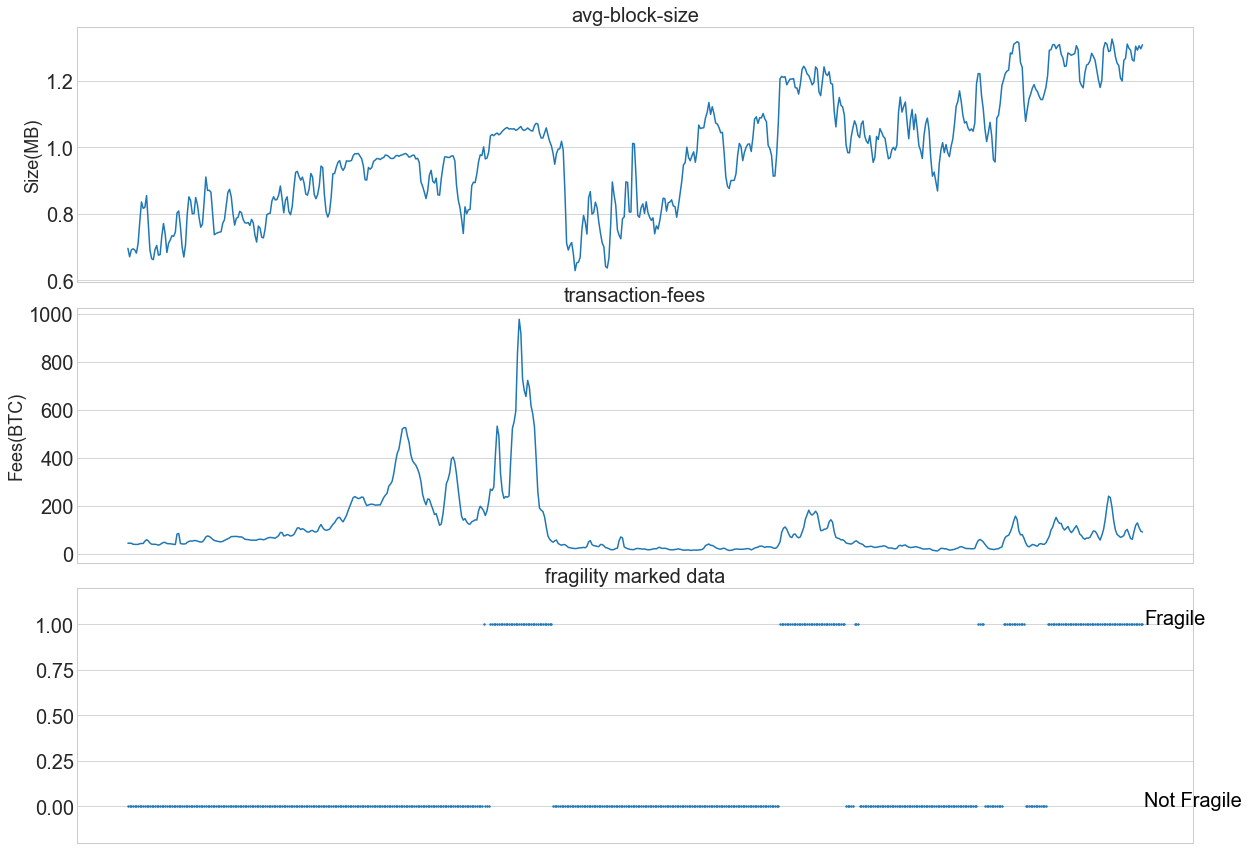

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 15))
plt.subplots_adjust(wspace =0, hspace =0.1)

ax1.plot(df['Timestamp'].values[:600], df['avg-block-size'].values[:600])
ax2.plot(df['Timestamp'].values[:600], df['transaction-fees'].values[:600])
ax3.scatter(df['Timestamp'].values[:600], df['fragility'].values[:600], s=2)

half_year_locator = mdates.MonthLocator(interval=5)
ax1.xaxis.set_major_locator(half_year_locator)                                        
ax2.xaxis.set_major_locator(half_year_locator)                                        
ax3.xaxis.set_major_locator(half_year_locator)

ax1.set_title('avg-block-size', fontsize=20)
ax2.set_title('transaction-fees', fontsize=20)
ax3.set_title('fragility marked data', fontsize=20)

ax1.set_ylabel('Size(MB)', fontsize=18)
ax2.set_ylabel('Fees(BTC)', fontsize=18)

ax1.tick_params(axis='y', which='major', labelsize=20)
ax1.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.tick_params(axis='y', which='major', labelsize=20)
ax2.get_xaxis().set_visible(False)
ax2.tick_params(axis='y', which='major', labelsize=20)
ax3.set_ylim([-0.2, 1.2])

style = dict(size=20, color='black')
ax3.text('1', 0, "Not Fragile", ha='left', **style)
ax3.text('1', 1, "Fragile", ha='left', **style)

plt.show()

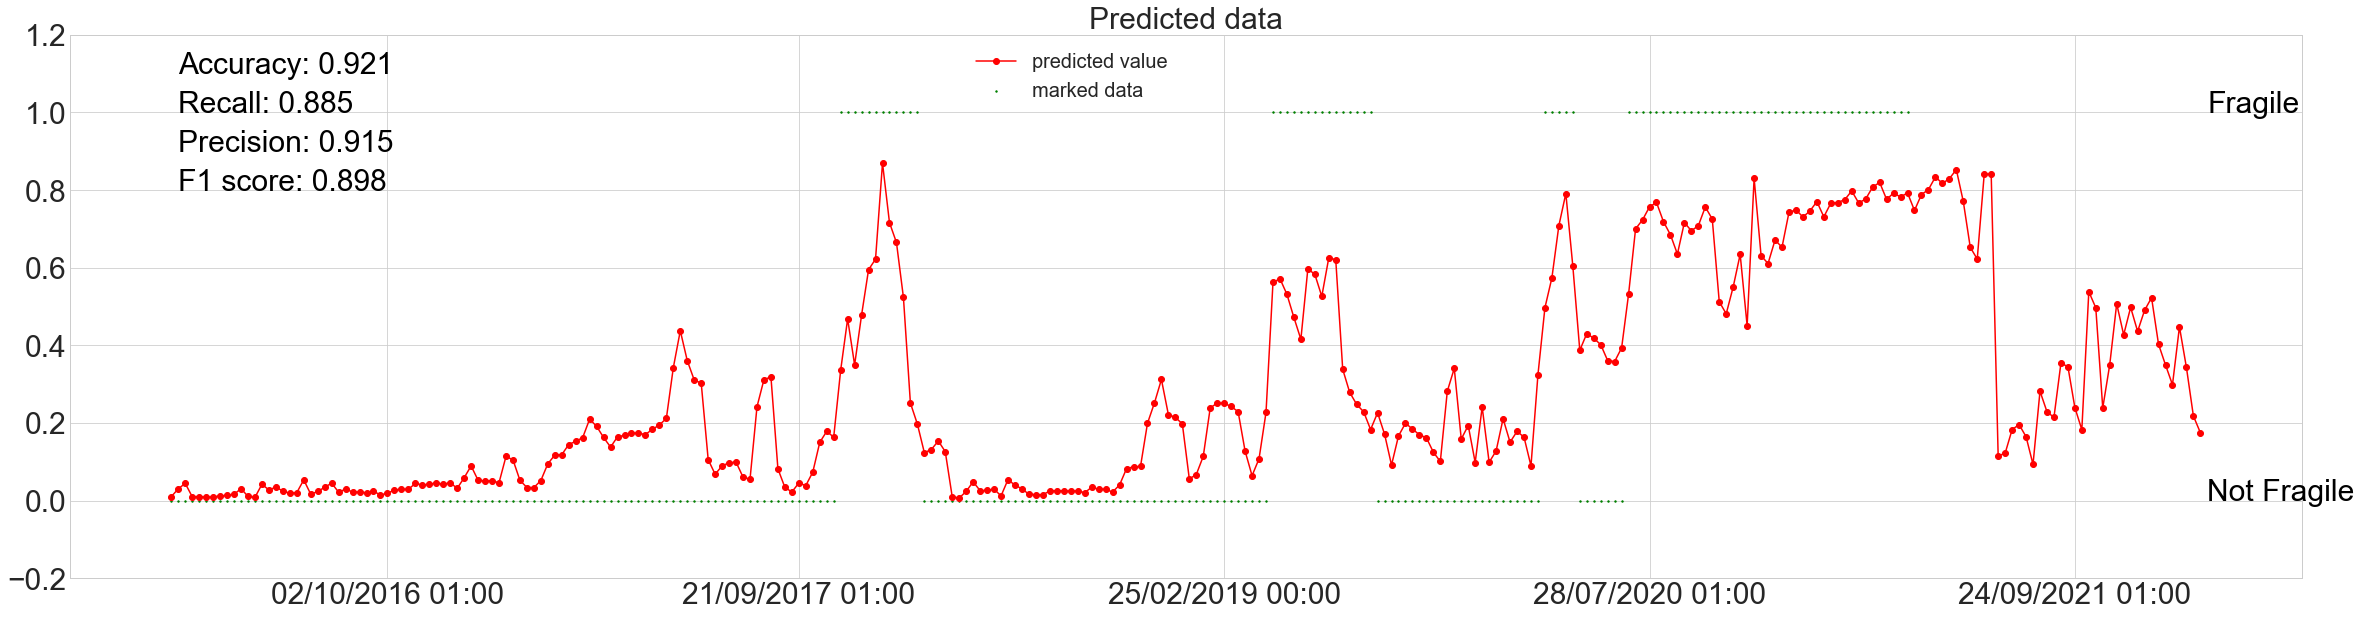

In [18]:
from sklearn import linear_model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model = linear_model.LogisticRegression()
df['avg-block-size'] = (df['avg-block-size'] - df['avg-block-size'].min()) / \
                                     (df['avg-block-size'].max() - df['avg-block-size'].min())
df['transaction-fees'] = (df['transaction-fees'] - df['transaction-fees'].min()) / \
                                 (df['transaction-fees'].max() - df['transaction-fees'].min())

train_df = df.sample(frac=0.6, random_state=0, axis=0)
test_df = df[~df.index.isin(train_df.index)]
model.fit(train_df[['avg-block-size', 'transaction-fees']].values, train_df['fragility'].values)
score = model.score(test_df[['avg-block-size', 'transaction-fees']].values, test_df['fragility'].values)
pred_label = model.predict(test_df[['avg-block-size', 'transaction-fees']].values)
prob = model.predict_proba(test_df[['avg-block-size', 'transaction-fees']].values)[:, 1]



f, ax = plt.subplots(figsize = (40, 10))

ax.scatter(test_df['Timestamp'].values[:250], test_df['fragility'].values[:250], s=2, c='g', marker='o', label='marked data')
ax.plot(test_df['Timestamp'].values, prob, '-ro', label='predicted value')

style = dict(size=30, color='black')
ax.text('1', 0, "Not Fragile", ha='left', **style)
ax.text('1', 1, "Fragile", ha='left', **style)

half_year_locator = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(half_year_locator)

ax.set_title('Predicted data', fontsize=30)

ax.text(1, 0.8, 'F1 score: %.3f' % f1_score(test_df['fragility'].values, pred_label.astype('int64'), average='macro'), **style)
ax.text(1, 0.9, 'Precision: %.3f' % precision_score(test_df['fragility'].values, pred_label.astype('int64'), average='macro'), **style)
ax.text(1, 1.0, 'Recall: %.3f' % recall_score(test_df['fragility'].values, pred_label.astype('int64'), average='macro'), **style)
ax.text(1, 1.1, 'Accuracy: %.3f' % accuracy_score(test_df['fragility'].values, pred_label.astype('int64')), **style)

ax.tick_params(axis='x', which='major', labelsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)
ax.set_ylim([-0.2, 1.2])
ax.legend(loc="upper right", bbox_to_anchor=(0.5, 1.0), ncol=1, fancybox=True, shadow=True, fontsize=20)
plt.show()

In [8]:
test_df['fragility'].value_counts()

0    211
1     81
Name: fragility, dtype: int64